In [0]:
# REINFORCE: MC policy gradient: https://www.youtube.com/watch?v=GOBvUA9lK1Q

In [0]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
!pip install gym box2d-py gym[box2d]
# !pip install gym[box2d] 

In [0]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(PolicyNetwork, self).__init__()

        self.input_dims = input_dims
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, observation):
        state = T.tensor(observation).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [0]:
class Agent(object):
    def __init__(self, lr, input_dims, gamma=0.99, n_actions=4, l1_size=128, 
                 l2_size=128):
        self.gamma = gamma
        self.reward_memory = []
        self.action_memory = []
        self.gamma = gamma
        self.n_actions = n_actions
        self.policy = PolicyNetwork(lr, input_dims, l1_size, l2_size, n_actions)

    def choose_action(self, observation):
#        with T.no_grad():
        probs = F.softmax(self.policy.forward(observation))
        action_probs = T.distributions.Categorical(probs)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        return action.item()

    def store_reward(self, reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()
        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1
            for k in range(t, len(self.reward_memory)):
                G_sum += self.reward_memory[k] * discount
                discount *= self.gamma

            G[t] = G_sum
        mean = np.mean(G)
        std = np.std(G) if np.std(G) > 0 else 1
        G = (G - mean) / std

        G = T.tensor(G, dtype=T.float).to(self.policy.device)

        loss = 0
        for g, log_prob in zip(G, self.action_memory):
            loss += -g * log_prob

        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []


In [0]:
import gym
import random
from collections import deque

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Episode 99 : Average Reward -165.557
Episode 199 : Average Reward -131.089
Episode 299 : Average Reward -115.035
Episode 399 : Average Reward -47.949
Episode 499 : Average Reward 2.443
Episode 599 : Average Reward 32.004
Episode 699 : Average Reward 66.046
Episode 799 : Average Reward 62.066
Episode 899 : Average Reward 78.928
Episode 999 : Average Reward 33.887
Episode 1099 : Average Reward 133.766
Episode 1199 : Average Reward 206.905
Episode 1299 : Average Reward 207.665
Episode 1399 : Average Reward 130.809
Episode 1499 : Average Reward 162.426
Episode 1599 : Average Reward 190.798
Episode 1699 : Average Reward 176.997
Episode 1799 : Average Reward 205.549
Episode 1899 : Average Reward 201.728
Episode 1999 : Average Reward 208.268
Episode 2099 : Average Reward 177.200
Episode 2199 : Average Reward 142.019
Episode 2299 : Average Reward 174.849
Episode 2399 : Average Reward 193.719
Episode 2499 : Average Reward 150.786


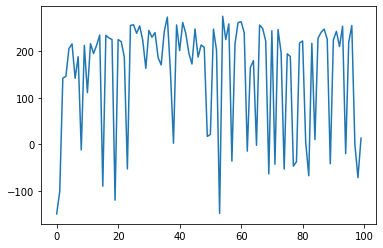

In [7]:
env = gym.make('LunarLander-v2')
#env.seed(0)
#T.manual_seed(0)
#np.random.seed(0)

agent = Agent(lr=0.001, input_dims=[8])

score_history = deque(maxlen=100)
score = 0
n_episodes = 2500

for i in range(n_episodes):
    #print("Episode: ", i, ' score', score)
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.store_reward(reward)
        observation = observation_
        score += reward

    score_history.appendleft(score)
    agent.learn()

    print('\rEpisode {} : Average Reward {:.3f}'.format(i, np.mean(score_history)), end="")
    if (i + 1) % 100 == 0:
        print('\rEpisode {} : Average Reward {:.3f}'.format(i, np.mean(score_history)))

import matplotlib.pyplot as plt
plt.plot(score_history)
plt.show()